In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.style.use('ggplot')

In [3]:
df = pd.read_csv('1630500298_Names_2010Census_Top1000.csv')
df.head()

,SURNAME,RANK,FREQUENCY,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,SMITH,1,"24,42,977",NaN,NaN,NaN,NaN
1,JOHNSON,2,"19,32,812",NaN,NaN,NaN,NaN
2,WILLIAMS,3,"16,25,252",NaN,NaN,NaN,NaN
3,BROWN,4,"14,37,026",NaN,NaN,NaN,NaN
4,JONES,5,"14,25,470",NaN,NaN,NaN,NaN


In [4]:
# excluding empty columns
df = df.iloc[:,:3]
df.head()

,SURNAME,RANK,FREQUENCY
0,SMITH,1,"24,42,977"
1,JOHNSON,2,"19,32,812"
2,WILLIAMS,3,"16,25,252"
3,BROWN,4,"14,37,026"
4,JONES,5,"14,25,470"


In [5]:
df.dtypes

SURNAME      object
RANK         object
FREQUENCY    object
dtype: object

In [6]:
def obj_to_int(col):
    for i in range(len(col)):
        col[i] = col[i].replace(',', '')
    
    return col

In [7]:
df['RANK'] = obj_to_int(df['RANK']).astype('int')
df['FREQUENCY'] = obj_to_int(df['FREQUENCY']).astype('int')
df.dtypes

<ipython-input-6-bf14d04619bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = col[i].replace(',', '')


SURNAME      object
RANK          int64
FREQUENCY     int64
dtype: object

In [8]:
df.head()

,SURNAME,RANK,FREQUENCY
0,SMITH,1,2442977
1,JOHNSON,2,1932812
2,WILLIAMS,3,1625252
3,BROWN,4,1437026
4,JONES,5,1425470


In [9]:
df.dtypes

SURNAME      object
RANK          int64
FREQUENCY     int64
dtype: object

In [10]:
# add column containing fraction of Freq
Total_Freq = df['FREQUENCY'].sum()
print("Total Freq: {}".format(Total_Freq))

df['FREQUENCY_RATIO'] = df['FREQUENCY']/Total_Freq
df.head()

Total Freq: 120848141


,SURNAME,RANK,FREQUENCY,FREQUENCY_RATIO
0,SMITH,1,2442977,0.020215
1,JOHNSON,2,1932812,0.015994
2,WILLIAMS,3,1625252,0.013449
3,BROWN,4,1437026,0.011891
4,JONES,5,1425470,0.011796


In [11]:
# Now add columns containign logarithmic values of RANK and frequency ratio
df['LOG_RANK'] = np.log(df['RANK'])
df['LOG_FREQUENCY_RATIO'] = np.log(df['FREQUENCY_RATIO'])

df.head()

,SURNAME,RANK,FREQUENCY,FREQUENCY_RATIO,LOG_RANK,LOG_FREQUENCY_RATIO
0,SMITH,1,2442977,0.020215,0.000000,-3.901317
1,JOHNSON,2,1932812,0.015994,0.693147,-4.135559
2,WILLIAMS,3,1625252,0.013449,1.098612,-4.308872
3,BROWN,4,1437026,0.011891,1.386294,-4.431959
4,JONES,5,1425470,0.011796,1.609438,-4.440033


In [12]:
df.dtypes

SURNAME                 object
RANK                     int64
FREQUENCY                int64
FREQUENCY_RATIO        float64
LOG_RANK               float64
LOG_FREQUENCY_RATIO    float64
dtype: object

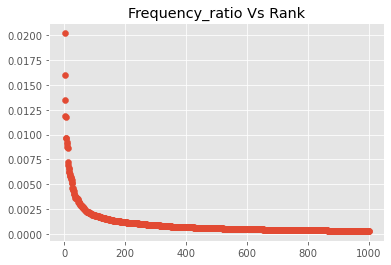

In [13]:
# Freq_ration Vs Rank
plt.scatter(df.RANK, df.FREQUENCY_RATIO)
plt.title("Frequency_ratio Vs Rank")
plt.show()

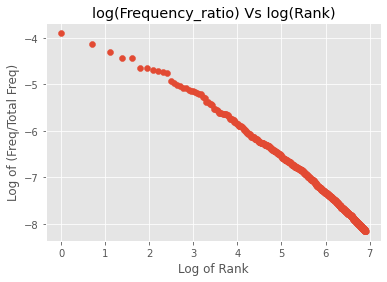

In [14]:
# loglog plot of Freq_ration vs RANK
plt.scatter(df.LOG_RANK, df.LOG_FREQUENCY_RATIO)
plt.title('log(Frequency_ratio) Vs log(Rank)')
plt.xlabel('Log of Rank')
plt.ylabel('Log of (Freq/Total Freq)')
plt.show()

In [15]:
# Our equation is log(Freq_fraction) = b*log(RANK) + log(a)
# first lets split the data 
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]

# Now train the linear regression model to fit this data.
from sklearn import linear_model

reg = linear_model.LinearRegression()
train_rank = np.asanyarray(train[['LOG_RANK']])
train_freq = np.asanyarray(train[['LOG_FREQUENCY_RATIO']])

reg.fit(train_rank, train_freq)

# to get the value of Intercept we need to take exponent of intercept obtained using regression 
# as we have taken natural logs on both sides
Exponent = reg.coef_[0][0]
Intercept = np.exp(reg.intercept_[0])

print("Exponent: {}\nIntercept: {}".format(Exponent, Intercept))

Exponent: -0.7500908006056741
Intercept: 0.056816532918768176


In [16]:
reg.intercept_

array([-2.86792792])

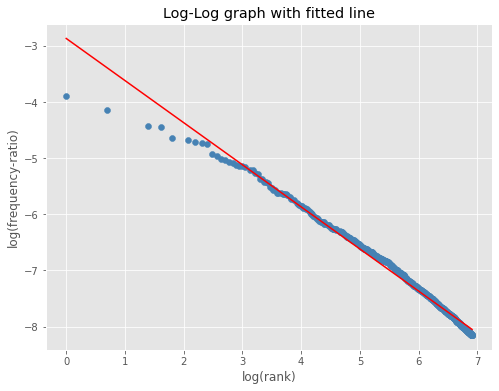

In [17]:
# Visualizing out fitted line
fig = plt.figure(figsize=(8,6))
plt.scatter(train.LOG_RANK, train.LOG_FREQUENCY_RATIO, color='steelblue')
plt.plot(train.LOG_RANK, reg.coef_[0][0]*train.LOG_RANK + reg.intercept_[0], '-r')
plt.title("Log-Log graph with fitted line")
plt.xlabel('log(rank)')
plt.ylabel('log(frequency-ratio)')
plt.show()

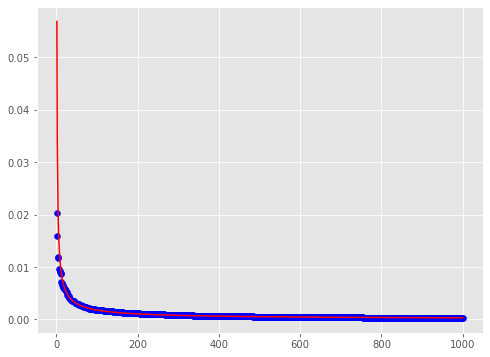

In [18]:
# Now plot the fitted graph on power-law distribution
# before that get a and b
a = np.exp(reg.intercept_[0])

fig = plt.figure(figsize=(8,6))
plt.scatter(train.RANK, train.FREQUENCY_RATIO, color='blue')
plt.plot(train.RANK, a*(train.RANK**reg.coef_[0][0]), '-r')

plt.show()

In [19]:
train.head()

,SURNAME,RANK,FREQUENCY,FREQUENCY_RATIO,LOG_RANK,LOG_FREQUENCY_RATIO
0,SMITH,1,2442977,0.020215,0.000000,-3.901317
1,JOHNSON,2,1932812,0.015994,0.693147,-4.135559
3,BROWN,4,1437026,0.011891,1.386294,-4.431959
4,JONES,5,1425470,0.011796,1.609438,-4.440033
5,GARCIA,6,1166120,0.009649,1.791759,-4.640853


In [20]:
# Now add column to train with predicted freq_fraction

train['FREQUENCY_RATIO_HAT'] = a*(train.RANK**reg.coef_[0][0])
train.head()

<ipython-input-20-d9a60c08f9db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['FREQUENCY_RATIO_HAT'] = a*(train.RANK**reg.coef_[0][0])


,SURNAME,RANK,FREQUENCY,FREQUENCY_RATIO,LOG_RANK,LOG_FREQUENCY_RATIO,FREQUENCY_RATIO_HAT
0,SMITH,1,2442977,0.020215,0.000000,-3.901317,0.056817
1,JOHNSON,2,1932812,0.015994,0.693147,-4.135559,0.033781
3,BROWN,4,1437026,0.011891,1.386294,-4.431959,0.020085
4,JONES,5,1425470,0.011796,1.609438,-4.440033,0.016990
5,GARCIA,6,1166120,0.009649,1.791759,-4.640853,0.014818


### ``Evaluation``

In [21]:
from sklearn.metrics import r2_score

test_rank = np.asanyarray(test[['LOG_RANK']])
test_freq = np.asanyarray(test[['LOG_FREQUENCY_RATIO']])

test_freq_predicted = reg.predict(test_rank)

# We'll compare our test results using three metrices, as follows:

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_freq_predicted - test_freq)))    # Mean absolute Error
print("Residual sum of squares (MSE): %.2f" % np.mean((test_freq_predicted - test_freq) ** 2))    # Mean squared Error
print("R2-score: %.2f" % r2_score(test_freq , test_freq_predicted))    # Root mean squared error

Mean absolute error: 0.05
Residual sum of squares (MSE): 0.01
R2-score: 0.99
